In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from pysankey2 import Sankey
import matplotlib as mpl
from pathlib import Path
import os.path as op
import pandas as pd
import numpy as np
import json
import os

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [4]:
bpath = Path('../data/clustering/BNU1/similarities/')
sims = {_: pd.read_hdf(_) for _ in bpath.rglob('*similarity*h5')}
cons = {_: pd.read_hdf(_) for _ in bpath.rglob('*consistency*h5')}
dists = {tuple(_.name.split('_')[0:2]): np.loadtxt(_) for _ in bpath.rglob('*distmat*txt')}

In [5]:
def meta_stack(kvp):
    df = None
    for k, v in kvp.items():
        dset, atlas = tuple(k.name.split('_')[0:2])
        v['dataset'] = dset
        v['atlas'] = atlas
        df = pd.concat([df, v])
    return df

df_sim = meta_stack(sims)
df_con = meta_stack(cons)

In [6]:
def reindex(v, newl=None):
    # Bump larger clusters to start of list
    labs, counts = np.unique(v, return_counts=True)
    if newl is None:
        newl = np.argsort(np.argsort(counts)[::-1])
    newv = np.empty_like(v)
    for oldx, newdx in zip(np.sort(labs), newl):
        newv[np.where(v == oldx)] = newdx
    return newv


def cluster_and_plot(df_sim, dmat, anno=False, aname=''):
    dmat = 1 - dmat
    clf = AgglomerativeClustering(n_clusters=None, affinity='precomputed',
                                  linkage='complete',
                                  distance_threshold=np.percentile(dmat, 90))
    labs = clf.fit_predict(dmat)
    labs = reindex(labs)
    unique, counts = np.unique(labs, return_counts=True)

    fig = plt.figure(figsize=(20, len(unique)*5))

    clustering = []
    for _, (l, c) in enumerate(zip(unique, counts)):
        locs = np.where(labs == l)[0]
        tdf = df_sim.iloc[locs]
        signature = np.mean(tdf['rank_corr'])
        clustering += [{
            'label': l,
            'members': locs,
            'signature': signature
        }]
        
        plt.subplot(1, len(unique), _+1)
        if anno:
            plt.xlabel('Label: {0}  |  N: {1}'.format(l, len(locs)))
            plt.title(aname)
        plt.imshow(signature, cmap='cividis')
        plt.yticks([])
        plt.xticks([])

    plt.show()
    return labs, clustering


def plot_resorted(distmat, label_list):
    csize = [len(_) for _ in label_list]
    start = [sum(csize[:_]) for _ in range(len(csize))]

    order = np.concatenate(label_list)
    resorted = distmat[:, order][order]
    
    f = plt.figure(figsize=(10, 10))
    ax = f.add_subplot(111)
    plt.imshow(resorted, cmap='inferno')

    for s, l in zip(start, csize):
        rect = patches.Rectangle((s-.5, s-0.5), l, l, linewidth=3, edgecolor='w',
                                 facecolor='none')
        ax.add_patch(rect)

    plt.yticks([])
    plt.xticks([])

    plt.show()

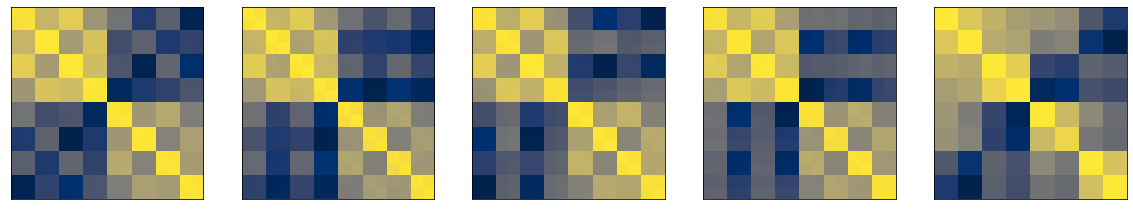

BNU1 aal


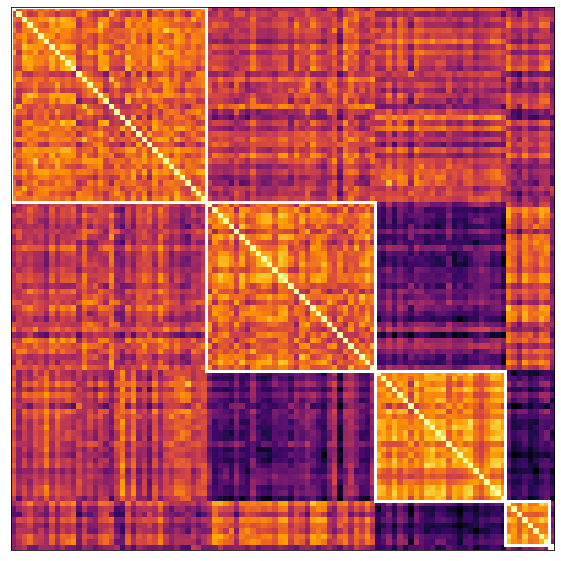

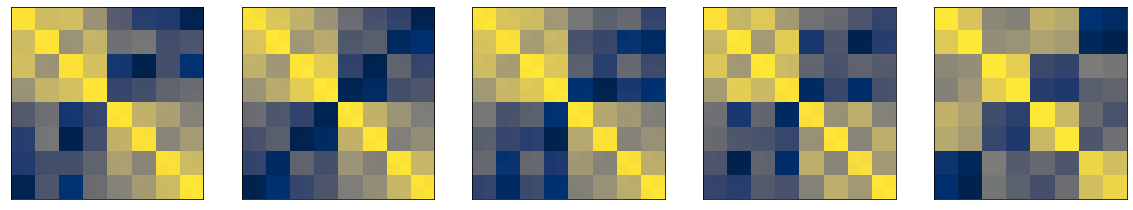

BNU1 cc2


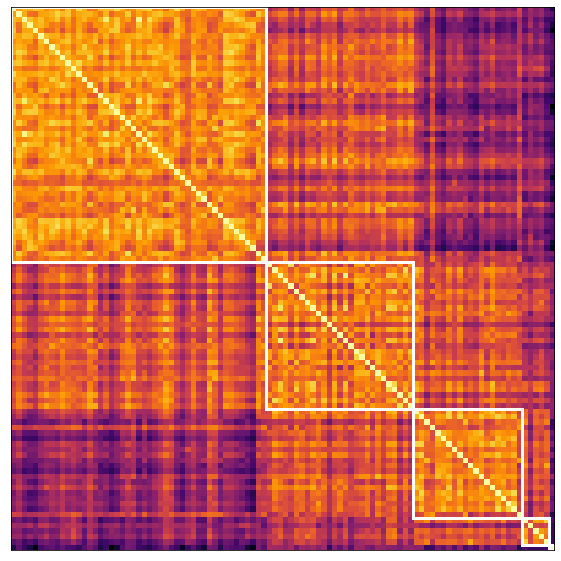

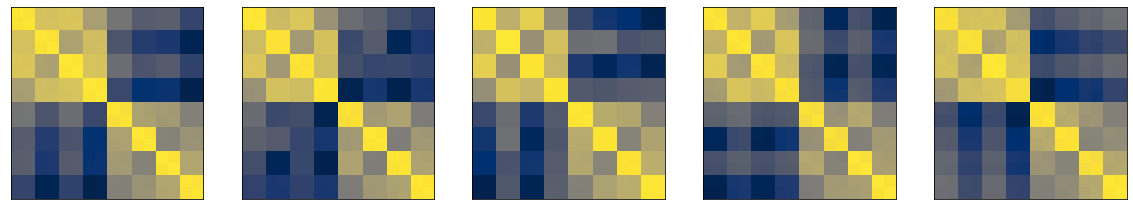

BNU1 des


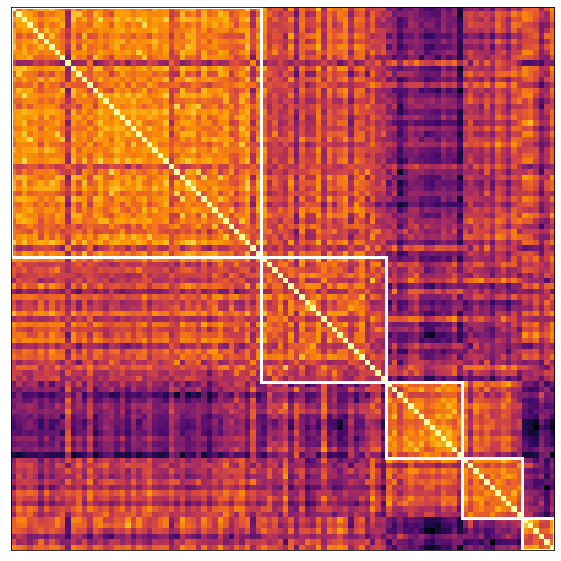

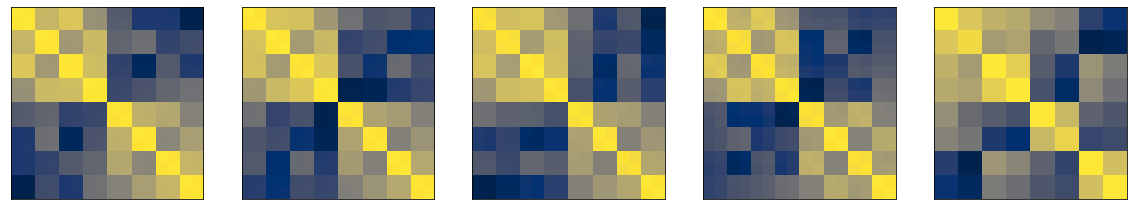

BNU1 hox


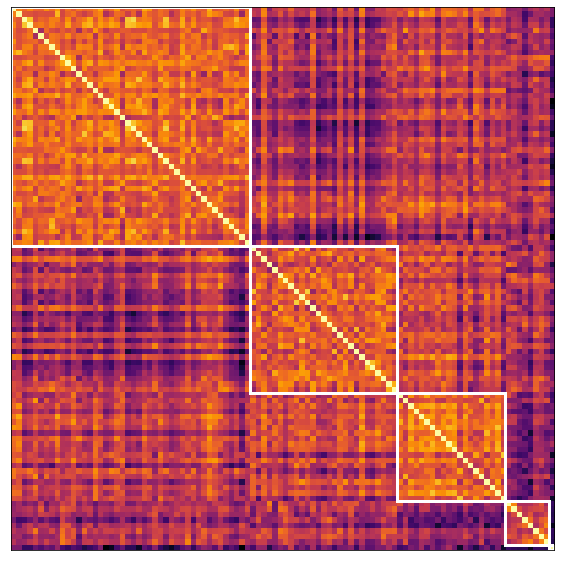

In [7]:
combos = df_sim.value_counts(['dataset', 'atlas']).index
sliced_da = lambda df, ds, at: df[(df['dataset'] == ds) & (df['atlas'] == at)]

clustering = {}
labels = {}
for ds, at in combos:
    tdf_c = sliced_da(df_con, ds, at)
    tdf_s = sliced_da(df_sim, ds, at)
    tdmat = dists[(ds, at)]
    labels[(ds, at)], clustering[(ds, at)] = cluster_and_plot(tdf_s, tdmat, aname=at)
    label_list = [_['members'] for _ in clustering[(ds, at)]]
    print(ds, at)
    plot_resorted(tdmat, label_list)


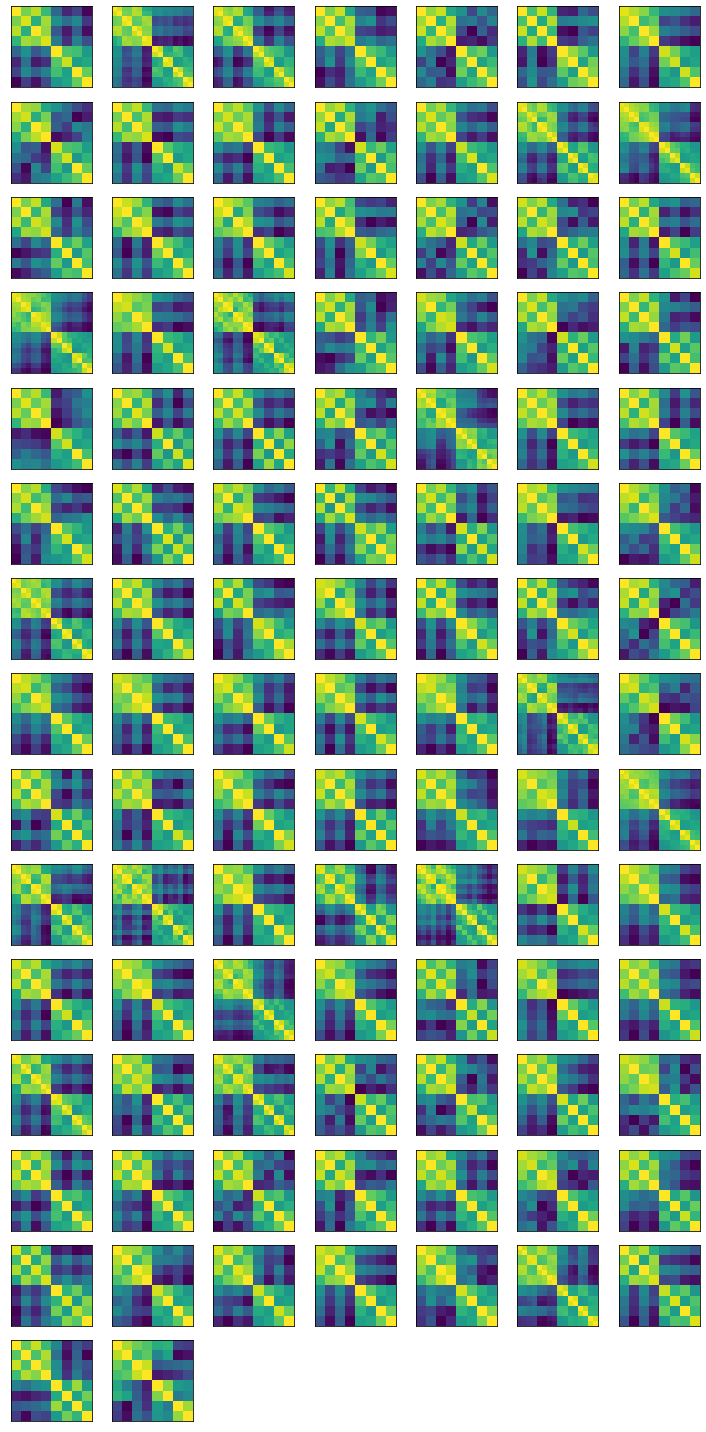

In [8]:
fig = plt.figure(figsize=(10, 20))

N = len(df_sim)
for idx, row in df_sim.iterrows():
    plt.subplot(15, 7, idx+1)
    plt.imshow(row.rank_corr)
    plt.yticks([])
    plt.xticks([])

plt.tight_layout()
plt.show()

In [9]:
cluster_orders = {}
nc = 5

reid_mat = []
c1 = combos[0]
s1 = [np.reshape(_['signature'], -1) for _ in clustering[c1]]
cluster_orders[c1[1]] = list(range(nc))

for idx, c2 in enumerate(combos[1:]):
    s2 = [np.reshape(_['signature'], -1) for _ in clustering[c2]]
    ts = np.stack(s1 + s2)
    ts_sim = np.corrcoef(ts)
    mval = np.min(ts_sim)

    ts_sim[0:nc, 0:nc] = mval
    ts_sim[nc:nc+nc, nc:nc+nc] = mval

    locs = []

    for _ in range(nc):
        l = np.argmax(ts_sim[_, :])
        ts_sim[l,:] = mval
        ts_sim[:,l] = mval
        ts_sim[_,l] = 1
        ts_sim[l,_] = 1
        locs += [l - nc]

    cluster_orders[c2[1]] = np.argsort(locs)
    print(c1, c2)
    print(locs)

('BNU1', 'aal') ('BNU1', 'cc2')
[1, 2, 0, 3, 4]
('BNU1', 'aal') ('BNU1', 'des')
[1, 0, 2, 4, 3]
('BNU1', 'aal') ('BNU1', 'hox')
[1, 2, 0, 3, 4]


In [10]:
cois = ['subject', 'session', 'dataset']
df_clust = df_sim[cois].groupby(['subject', 'session']).max()

for idx, (k, v) in enumerate(labels.items()):
#     df_clust[k[1]+"old"] = v
    df_clust[k[1]] = reindex(v, newl=cluster_orders[k[1]])

df_clust

dataset  aal  cc2  des  hox
subject session                            
0025864 1          BNU1    2    2    4    2
        2          BNU1    1    0    0    0
0025865 1          BNU1    0    2    2    2
        2          BNU1    2    2    2    2
0025866 1          BNU1    2    2    0    2
...                 ...  ...  ...  ...  ...
0025911 2          BNU1    0    0    1    0
0025912 1          BNU1    0    2    4    1
        2          BNU1    1    1    1    1
0025913 1          BNU1    1    1    4    1
        2          BNU1    4    4    0    4

[100 rows x 5 columns]

(<Figure size 1080x1080 with 1 Axes>, <AxesSubplot:>)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


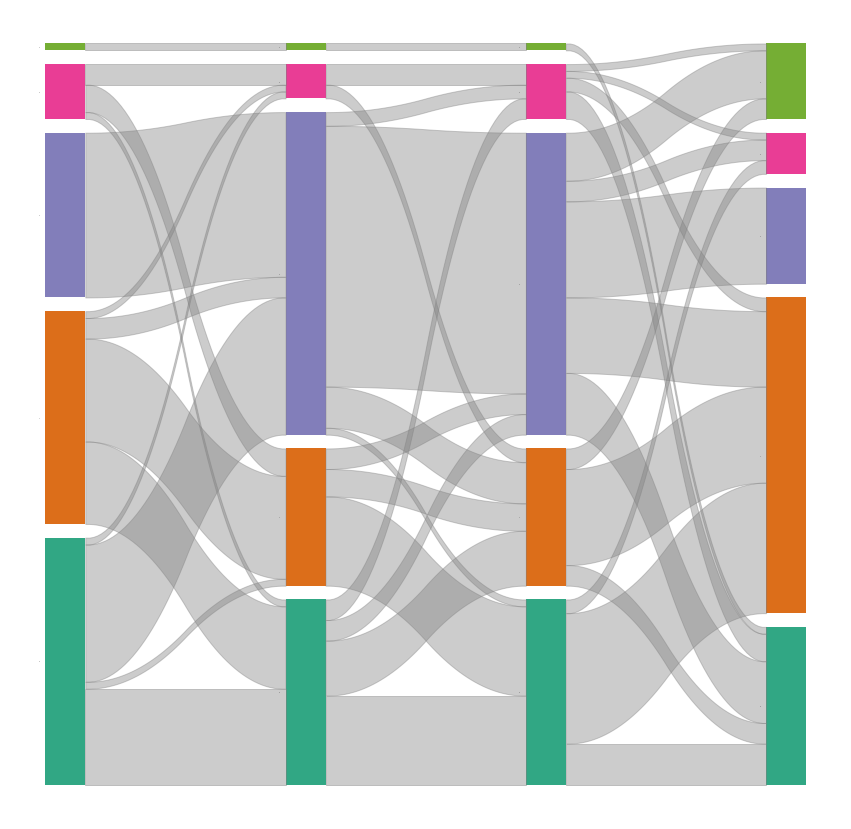

In [11]:
cm = mpl.cm.get_cmap('Dark2').colors

dfc2 = df_clust[['aal', 'cc2', 'hox', 'des']]
dfc2 = dfc2.rename(columns={'aal': 'layer1', 'cc2': 'layer2', 'des': 'layer4', 'hox': "layer3"})
dfc2 = dfc2.reset_index().drop(columns=['subject', 'session'])

# label_order = {'layer{0}'.format(_+1): list(range(5)) for _ in range(4)}
color_dict = {_: cm[_] for _ in range(5)}
cords = {"layer{0}".format(_+1): list(range(5)) for _, (k, v) in enumerate(cluster_orders.items())}

subject_clustering = Sankey(dfc2, colorMode='global', stripColor='gray',
                                colorDict= color_dict,
                                layerLabels=cords)

subject_clustering.plot(figSize=(15, 15), fontSize=0)

In [12]:
for idx, c1 in enumerate(combos):
    for jdx, c2 in enumerate(combos[idx+1:]):
        print(c1[1], c2[1])
        l1 = labels[c1]
        l2 = labels[c2]
        
        print(adjusted_mutual_info_score(l1, l2))
#         print(adjusted_rand_score(l1, l2))

aal cc2
0.35395773399386976
aal des
0.11472907491107827
aal hox
0.16787590627776156
cc2 des
0.15952852390153516
cc2 hox
0.3123801594459657
des hox
0.13224262785111196
